In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as functional
import torchvision
import torchvision.models as models
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from torchvision.datasets import CIFAR10
import pickle
import logging
import os
from scipy.spatial import distance
%matplotlib inline

/opt/miniconda3/envs/develop/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""シード値の固定"""
random_seed = 9999
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True

def load_cifar10(transform, train:bool):
    cifar10_dataset = CIFAR10(
                        root='/home/oshita/cleansing/data/cifar-10',
                        train=train,
                        download=False,
                        transform=transform
                        )
    return cifar10_dataset
    
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.2,0.2,0.2])
    ]
)
dataset = load_cifar10(transform=train_transform, train=True)
valid_ratio = 0.1                               # 検証用データの割合を指定
valid_size = int(len(dataset) * valid_ratio)    # 検証用データの数
train_size = len(dataset) - valid_size 
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
print(f'train_data:{len(train_dataset)}')
train_loader = DataLoader(
    train_dataset,          # データセットを指定
    batch_size=256,          # バッチサイズを指定
    shuffle=True,           # シャッフルの有無を指定
    drop_last=True,         # バッチサイズで割り切れないデータの使用の有無を指定
    pin_memory=True,        # 少しだけ高速化が期待できるおまじない
    num_workers=4           # DataLoaderのプロセス数を指定
)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

train_data:45000
cuda


In [3]:
model = models.vit_b_16(weights=torch.load('./models/vit_model.pth'))
model.to(device)
model.eval()
if(torch.cuda.device_count()>1):
        model = nn.DataParallel(model,device_ids=[0,1,2,3])

feat = {
        0:torch.tensor([]).to(device), 1:torch.tensor([]).to(device),2:torch.tensor([]).to(device),
        3:torch.tensor([]).to(device),4:torch.tensor([]).to(device),5:torch.tensor([]).to(device),
        6:torch.tensor([]).to(device),7:torch.tensor([]).to(device),8:torch.tensor([]).to(device),
        9:torch.tensor([]).to(device)
}
train_data = {
        0:torch.tensor([]).to(device), 1:torch.tensor([]).to(device),2:torch.tensor([]).to(device),
        3:torch.tensor([]).to(device),4:torch.tensor([]).to(device),5:torch.tensor([]).to(device),
        6:torch.tensor([]).to(device),7:torch.tensor([]).to(device),8:torch.tensor([]).to(device),
        9:torch.tensor([]).to(device)
}
trainloop = tqdm(train_loader, unit='batch', desc='| train | Epoch {:>3} |'.format(1))

with torch.no_grad():
    for data,labels in trainloop:
        data = data.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        feature=model(data)
        for cls in range(10):
                train_data[cls] = torch.cat((train_data[cls],data[labels==cls]))
                feat[cls] = torch.cat((feat[cls],feature[labels==cls]))
with open("./feature.pkl","wb") as f:
    pickle.dump(feat, f)

/opt/miniconda3/envs/develop/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
| train | Epoch   1 |: 100%|██████████| 175/175 [01:11<00:00,  2.45batch/s]


104606.23879929038
105813.78347361743
108556.14953916876
113660.77294669984
104800.53801501244
102629.1474967673
103550.18841944153
105499.02535008537
100370.54811487386
95559.83847325816
91944.660924628
88013.50658344738
84712.36689434697
81493.20293602669
78525.50862122093
77270.82776500288
74996.96213896784
71955.6990004779
70280.64017854282
68778.05823992584
[104606.23879929 105813.78347362 108556.14953917 113660.7729467
 104800.53801501 102629.14749677 103550.18841944 105499.02535009
 100370.54811487  95559.83847326  91944.66092463  88013.50658345
  84712.36689435  81493.20293603  78525.50862122  77270.827765
  74996.96213897  71955.69900048  70280.64017854  68778.05823993]
135058.91597645133
138651.78434654843
106505.9794999014
112245.79568397877
114935.95244645706
114069.22802324024
110687.5499690631
107842.22297149297
101932.61894878246
96895.09824346777
91304.60999302017
87743.1412503921
83722.25781698982
80559.21904668395
78439.18831636658
77455.75345303425
74656.71014142575


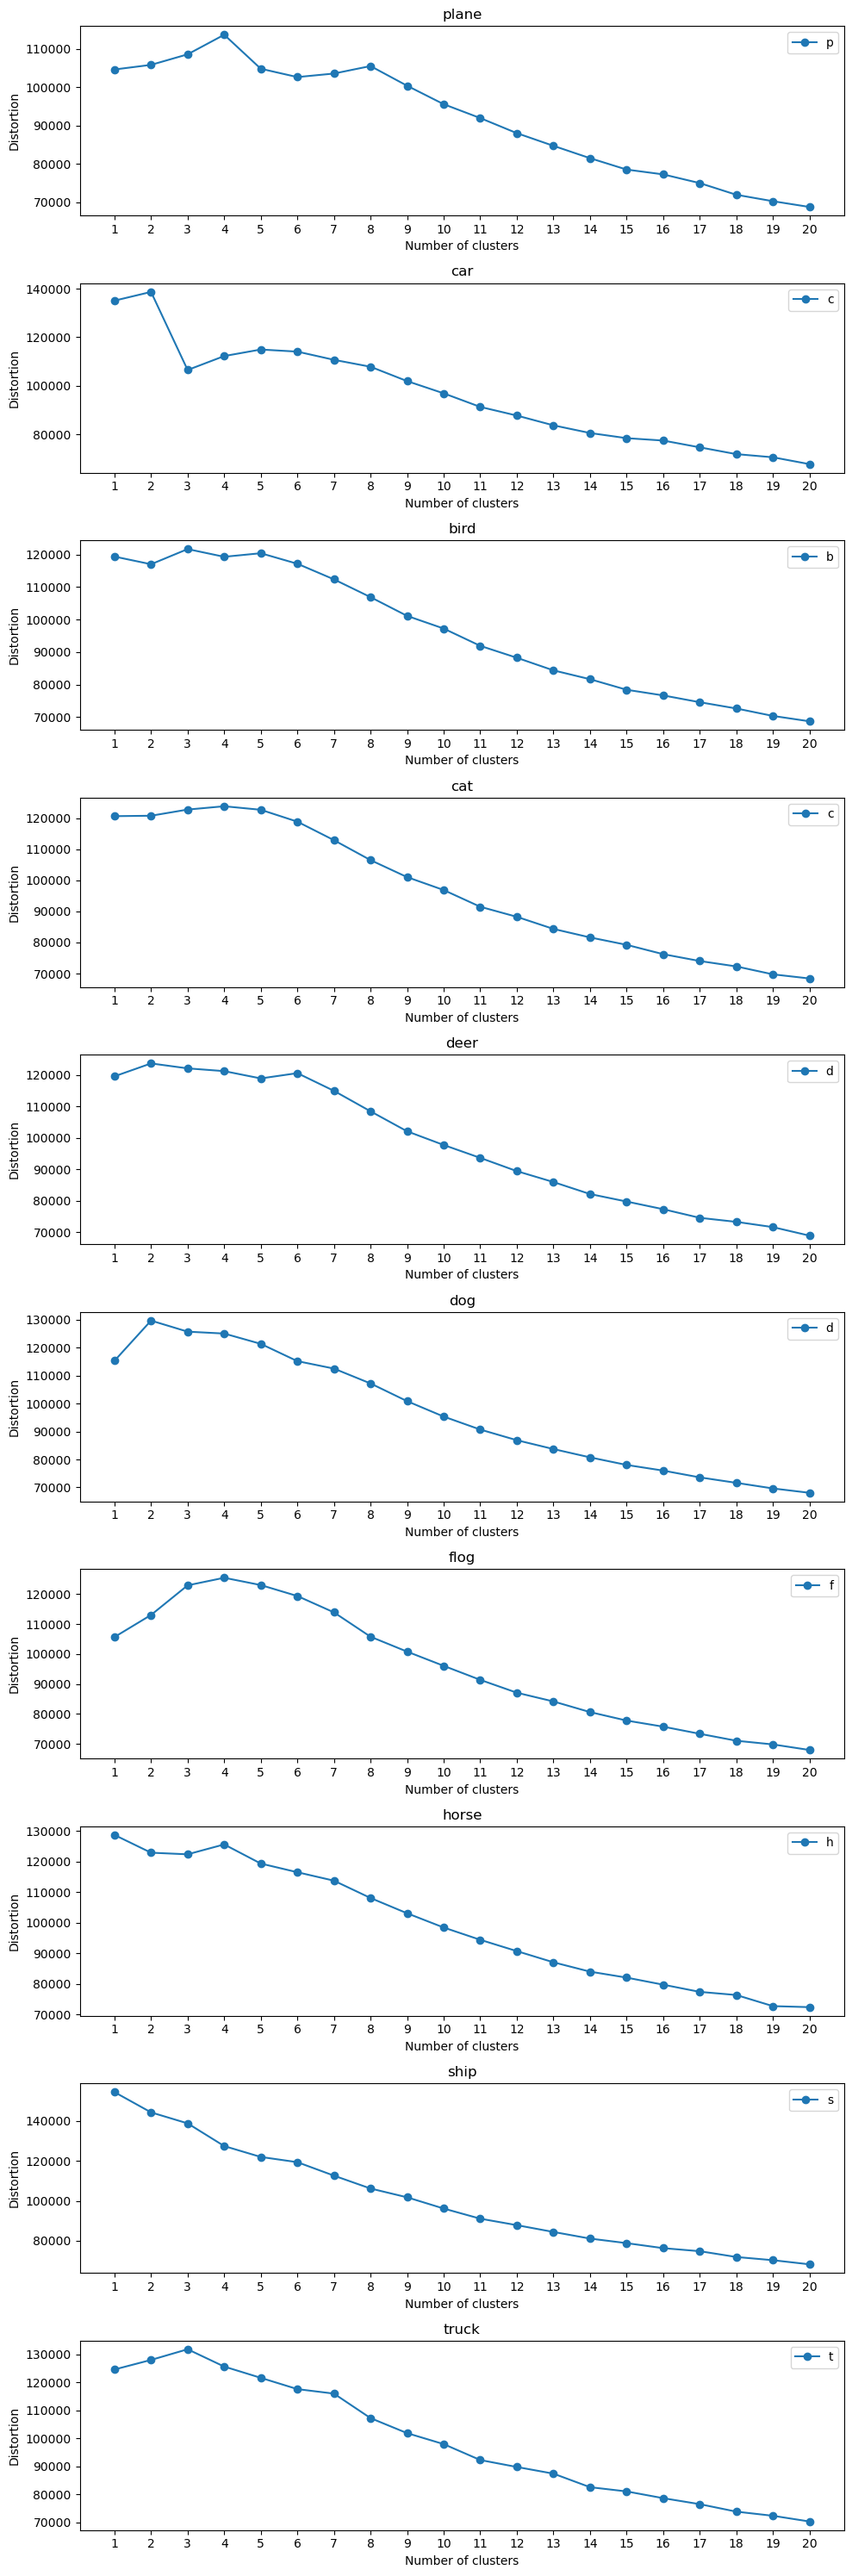

In [36]:
def maha_dis(data,mean):
    # 分散共分散行列を計算
    cov = np.cov(data.T)
    # 逆行列を計算
    cov_i = np.linalg.pinv(cov)
    dis=0
    for i in range(data.shape[0]):
        dis+=distance.mahalanobis(data[0], mean, cov_i)
    return dis
    
"""各クラスの最適なクラスタ数のめどをつける"""
_class = ['plane','car','bird','cat','deer','dog','flog','horse','ship','truck']
fig=plt.figure(figsize=(10,30),dpi=100)
clst_num=20
for i in range(10): 
    _feat = feat[i].to('cpu').detach().numpy().copy()
    distortions = np.zeros(clst_num)
    for j in range(1,clst_num+1): 
        dis=0
        gmm = GaussianMixture(n_components=j,n_init=10,max_iter=30,random_state=random_seed)
        gmm.fit(_feat)
        _pred = gmm.predict(_feat)
        """クラスタｋのマハラノビス距離"""
        for k in range(j):
            dis += maha_dis(_feat[_pred==k],gmm.means_[k])
        distortions[j-1] = dis
        print(dis)
        
    print(distortions)
    ax = fig.add_subplot(10,1,i+1)
    ax.plot(np.arange(1,clst_num+1),distortions,marker="o")
    ax.set_xticks(range(1,clst_num+1))
    ax.set_title(f"{_class[i]}")
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Distortion")
    ax.legend(''.join(f"{_class[i]}"), loc='upper right')
    plt.tight_layout()
plt.show()
# plt.savefig('./gmm_mahalanobis.png')

In [5]:
import pickle
with open('feature.pkl', 'rb') as f:
    feat = pickle.load(f)

target='plane'
_class = ['plane','car','bird','cat','deer','dog','flog','horse','ship','truck']
cluster=[20,20,20,20,20,20,20,20,20,20]
# cluster=[30,30,30,30,30,30,30,30,30,30]
index=_class.index(target)
num_clusters = cluster[index]
# _feat=feat[index].to('cpu').detach().numpy().copy()

# model = GaussianMixture(n_components=num_clusters,max_iter=30,n_iter=10,random_state=random_seed)
# model.fit(_feat.reshape(-1,1))
# pred = model.predict(_feat.reshape(-1,1))

# 各クラスタの枚数確認
# for i in range(num_clusters):
#     print(f'({i},{train_data[index][pred==i].shape[0]})',end=' ')
# for i in range(num_clusters):
#     x = _data[index][pred==i][:100]
#     # print(x)
#     img = torchvision.utils.make_grid(x,nrow=10,normalize=True)
#     img = functional.to_pil_image(img)
#     display(img)

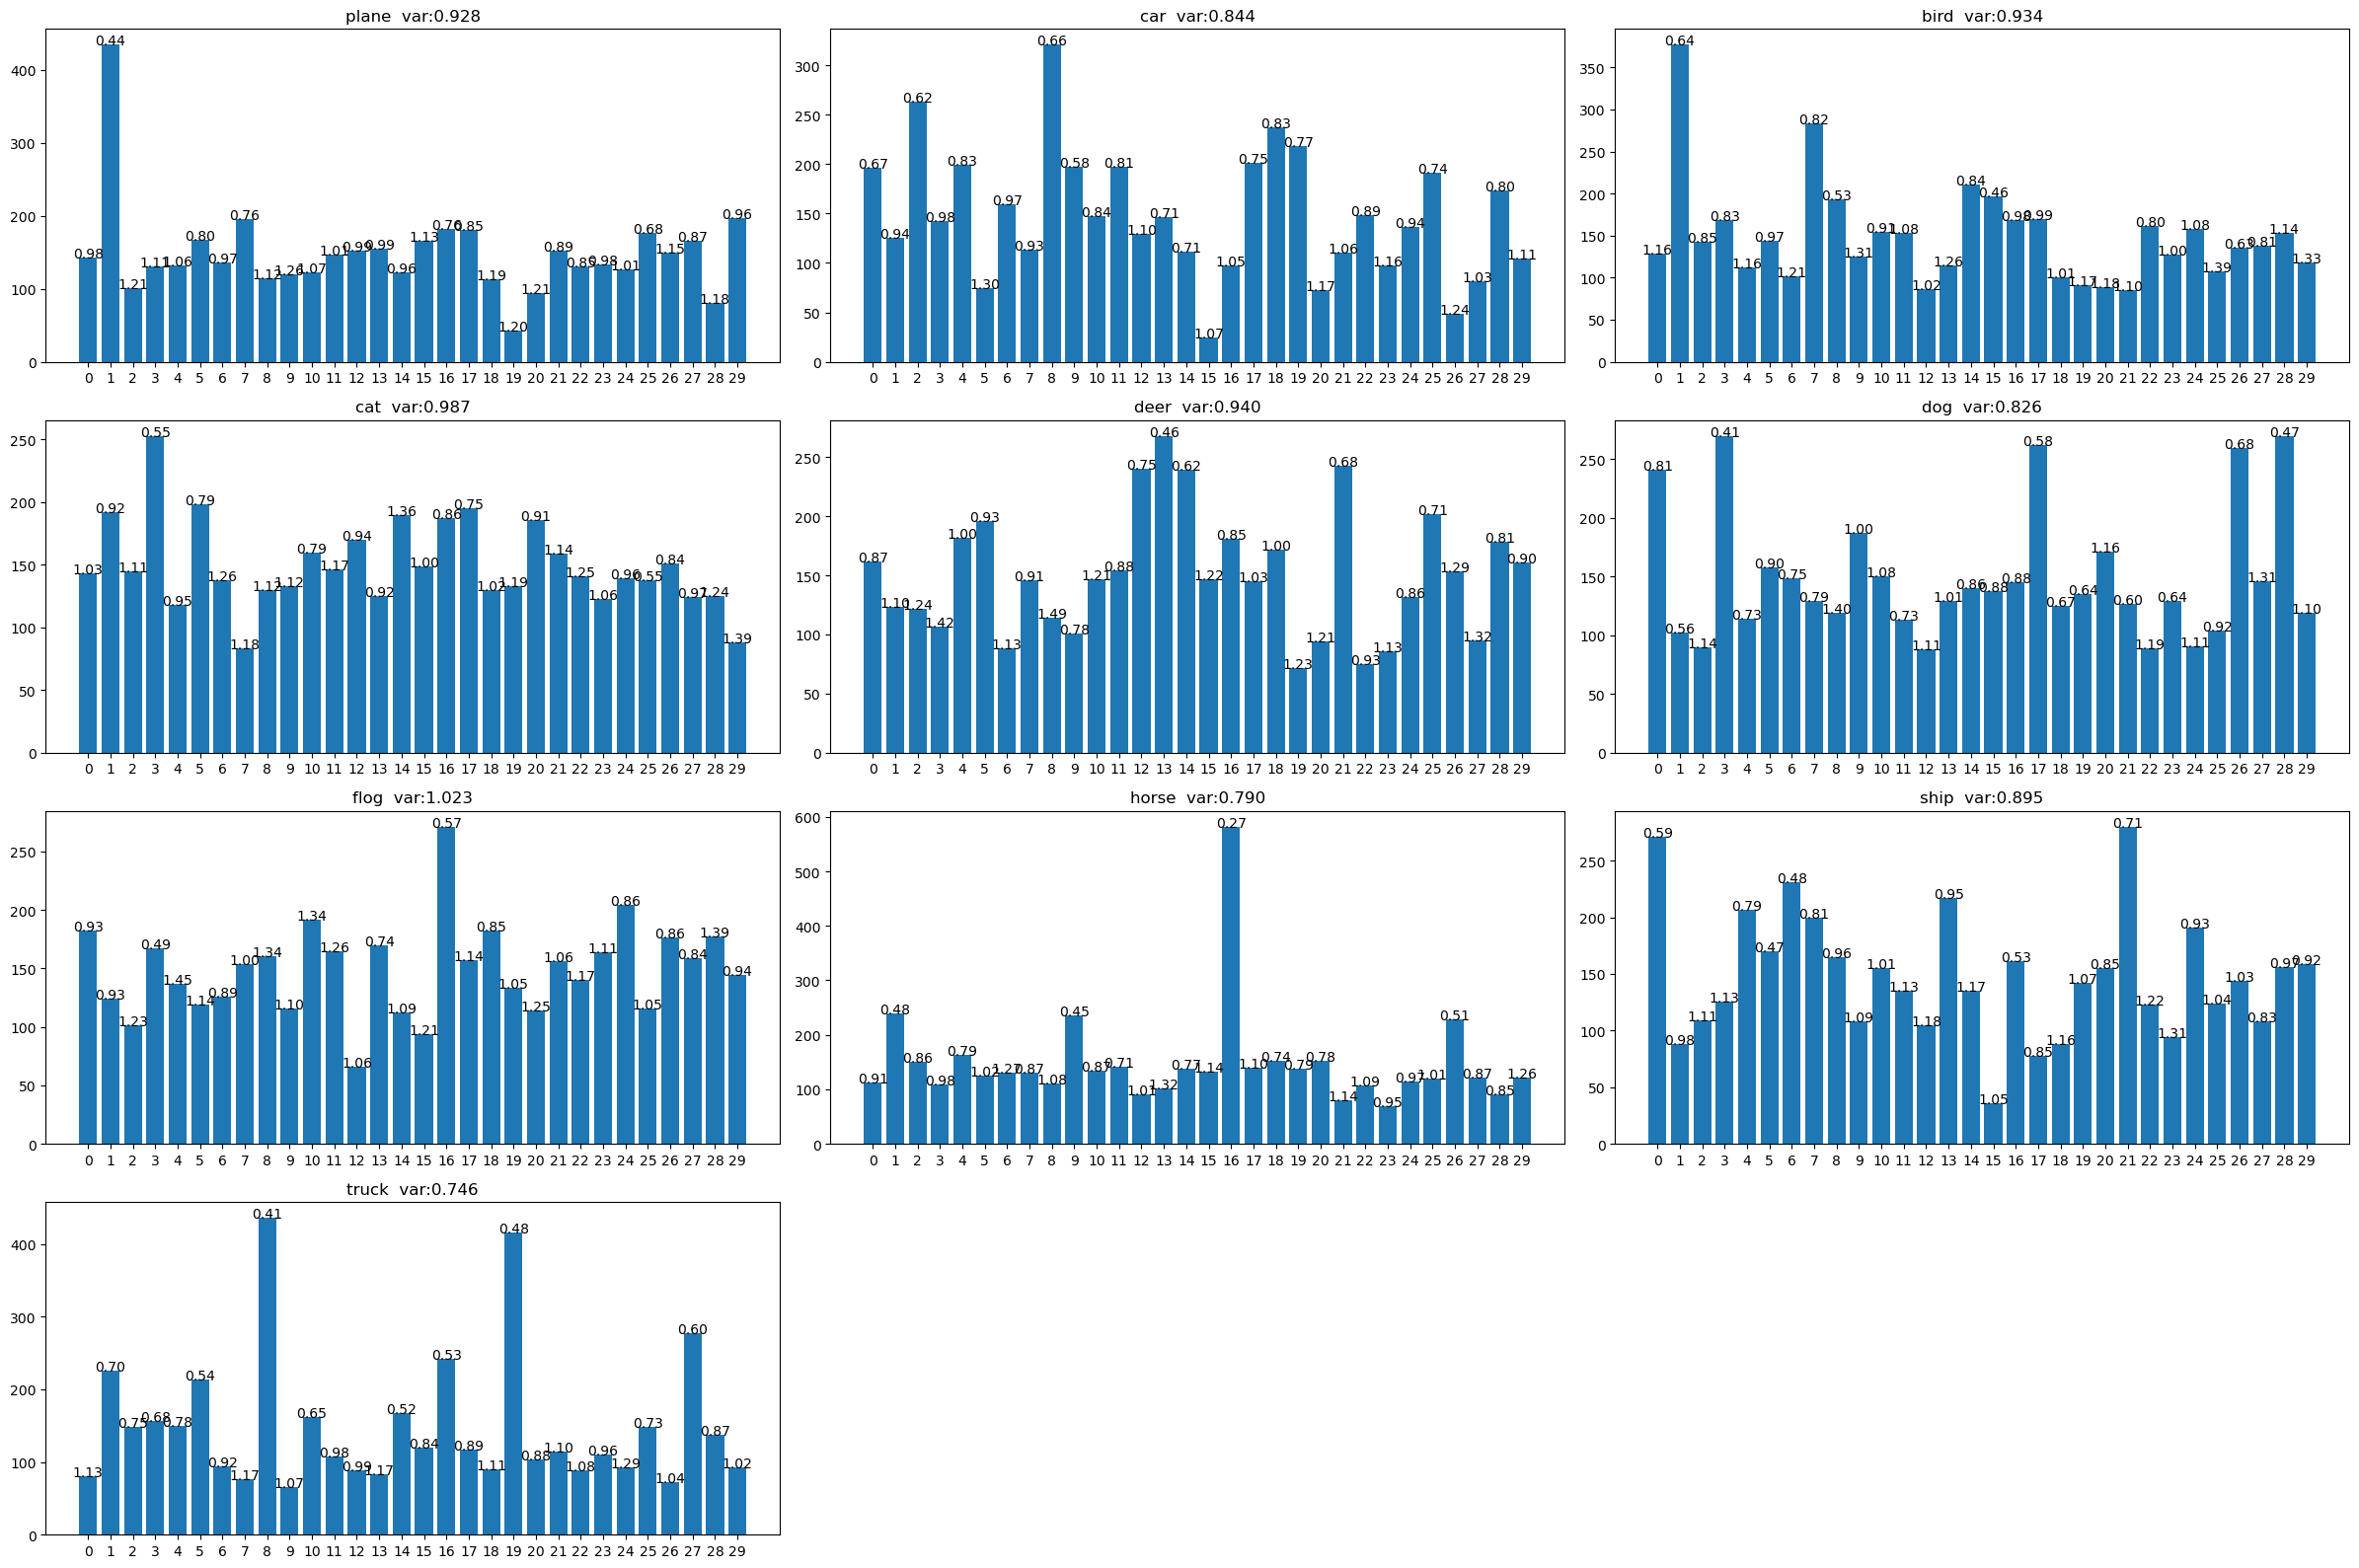

: 

In [6]:
fig_bar = plt.figure(figsize=(24, 16), dpi=100)

for i in range(10):    
    _feat = feat[i].to('cpu').detach().numpy().copy()
    _model = GaussianMixture(n_components=cluster[i],max_iter=30,random_state=random_seed)
    _model.fit(_feat)
    
    """各クラス間の分散及び、各クラスタ分散"""
    pred = _model.predict(_feat)
    height=np.array([len(pred[pred==j]) for j in range(cluster[i])])
    iner_var=np.array([(np.var(_feat[pred==k]))for k in range(cluster[i])])
    text = np.array([f'{iner_var[l]:.02f}' for l in range(cluster[i])])
    ax = fig_bar.add_subplot(4,3,i+1)
    ax.bar(np.arange(cluster[i]),height)
    ax.set_xticks(np.arange(cluster[i]))
    ax.set_title(f'{_class[i]}  var:{np.var(_feat):.03f}')
    for t in range(cluster[i]):
        ax.text(x=t,y=height[t],s=text[t],ha='center') 
    plt.tight_layout()
plt.show()